# EARLY FUSION: S1 + S2 (BALANCED)


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

BASE_DIR = Path("/content/drive/MyDrive/SA_CropType_SourceCoop")
TRAIN_DIR = BASE_DIR / "train"
LABELS_DIR = TRAIN_DIR / "labels"
S2_DIR = TRAIN_DIR / "imagery" / "s2"
S1_DIR = TRAIN_DIR / "imagery" / "s1"
OUT_DIR = BASE_DIR / "outputs"
META_DIR = OUT_DIR / "meta"
FIG_DIR = OUT_DIR / "figures" / "fusion"
TAB_DIR = OUT_DIR / "tables"

FIG_DIR.mkdir(parents=True, exist_ok=True)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)

!pip install xgboost -q
import xgboost as xgb
from datetime import datetime

print("✅ Kurulum tamam!")
print(f"⏰ Başlangıç: {datetime.now().strftime('%H:%M:%S')}")

✅ Kurulum tamam!
⏰ Başlangıç: 10:08:23


##  BALANCED DATASET YÜKLEME

In [ ]:
# BALANCED DATASET (12a'dan)
balanced_path = META_DIR / "tfc_smart_undersampled.csv"

if balanced_path.exists():
    tfc_selected = pd.read_csv(balanced_path)
    print(f"✅ BALANCED dataset: {len(tfc_selected):,} field")
else:
    raise FileNotFoundError("❌ tfc_smart_undersampled.csv bulunamadı! 12a'yı önce çalıştırın.")

TARGET_CROPS = [
    "Wine grapes",
    "Wheat",
    "Planted pastures (perennial)",
    "Lucerne/Medics"
]

print(f"\n  Sınıf dağılımı:")
for crop in TARGET_CROPS:
    count = len(tfc_selected[tfc_selected['crop'] == crop])
    print(f"    {crop:30s}: {count:,}")

print(f"\n⏱️  Tahmini süre: ~{len(tfc_selected)//80} dakika")

✅ BALANCED dataset: 5,419 field

  Sınıf dağılımı:
    Wine grapes                   : 2,000
    Wheat                         : 1,050
    Planted pastures (perennial)  : 1,326
    Lucerne/Medics                : 1,043

⏱️  Tahmini süre: ~67 dakika


##  S2 TEMPORAL FEATURE EXTRACTION

In [ ]:
# S2 Temporal fonksiyonları (12_TEMPORAL'den)

def smart_date_selection(tile_dir, max_dates=15):
    all_dates = sorted([d for d in tile_dir.iterdir() if d.is_dir()])
    if len(all_dates) == 0:
        return [], {}, []

    date_info = []
    for date_folder in all_dates:
        try:
            parts = date_folder.name.split('_')
            if len(parts) >= 3:
                year, month, day = int(parts[0]), int(parts[1]), int(parts[2])
                date_info.append({
                    'path': date_folder,
                    'year_month': f"{year}_{month:02d}",
                    'date_num': year * 10000 + month * 100 + day
                })
        except:
            continue

    if len(date_info) == 0:
        return all_dates[:max_dates], {}, []

    df = pd.DataFrame(date_info)
    monthly_counts = df.groupby('year_month').size()
    n_months = len(monthly_counts)
    dates_per_month = max(1, max_dates // n_months)

    selected_dates = []
    for year_month, group in df.groupby('year_month'):
        n_select = min(dates_per_month, len(group))
        if len(group) > n_select:
            indices = np.linspace(0, len(group)-1, n_select, dtype=int)
            selected = group.iloc[indices]
        else:
            selected = group
        selected_dates.extend(selected.to_dict('records'))

    selected_dates = sorted(selected_dates, key=lambda x: x['date_num'])[:max_dates]
    paths = [d['path'] for d in selected_dates]
    distribution = pd.DataFrame(selected_dates).groupby('year_month').size().to_dict()

    return paths, distribution, selected_dates

def extract_s2_temporal_features(tile_id, field_id, s2_dir, labels_dir, num_dates=15):
    features = {}

    try:
        label_path = labels_dir / f"{tile_id}_field_ids.tif"
        if not label_path.exists():
            return None

        with rasterio.open(label_path) as src:
            label_mask = src.read(1)

        field_mask = (label_mask == field_id)
        if field_mask.sum() == 0:
            return None

        tile_dir = s2_dir / str(tile_id)
        if not tile_dir.exists():
            return None

        date_folders, distribution, date_info = smart_date_selection(tile_dir, max_dates=num_dates)
        if len(date_folders) < 3:
            return None

        band_map = {'B2': 'B02', 'B3': 'B03', 'B4': 'B04', 'B8': 'B08'}
        band_values = {name: [] for name in band_map.keys()}
        ndvi_timeseries = []

        for date_folder in date_folders:
            date_str = date_folder.name
            date_bands = {}

            for band_short, band_full in band_map.items():
                band_file = date_folder / f"{tile_id}_{date_str}_{band_full}_10m.tif"
                if band_file.exists():
                    with rasterio.open(band_file) as src:
                        band_data = src.read(1)
                    field_vals = band_data[field_mask]
                    field_vals = field_vals[field_vals > 0]

                    if len(field_vals) > field_mask.sum() * 0.3:
                        date_bands[band_short] = field_vals
                        band_values[band_short].extend(field_vals.tolist())

            if 'B8' in date_bands and 'B4' in date_bands:
                nir = np.mean(date_bands['B8'])
                red = np.mean(date_bands['B4'])
                if (nir + red) > 0:
                    ndvi = (nir - red) / (nir + red)
                    ndvi_timeseries.append(ndvi)

        if len(ndvi_timeseries) < 3:
            return None

        # Static features
        for band, vals in band_values.items():
            if len(vals) > 0:
                features[f'{band}_mean'] = np.mean(vals)
                features[f'{band}_std'] = np.std(vals)
                features[f'{band}_min'] = np.min(vals)
                features[f'{band}_max'] = np.max(vals)
                features[f'{band}_median'] = np.median(vals)
            else:
                return None

        features['NDVI_mean'] = np.mean(ndvi_timeseries)
        features['NDVI_std'] = np.std(ndvi_timeseries)

        if all(k in features for k in ['B8_mean', 'B4_mean', 'B2_mean']):
            nir = features['B8_mean']
            red = features['B4_mean']
            blue = features['B2_mean']
            denom = nir + 6*red - 7.5*blue + 1
            features['EVI'] = 2.5 * (nir - red) / denom if denom != 0 else 0

        # TEMPORAL features
        ndvi_ts = np.array(ndvi_timeseries)
        n_obs = len(ndvi_ts)

        if n_obs > 1:
            x = np.arange(n_obs)
            slope, intercept = np.polyfit(x, ndvi_ts, 1)
            features['NDVI_trend'] = slope
            features['NDVI_intercept'] = intercept
        else:
            features['NDVI_trend'] = 0
            features['NDVI_intercept'] = ndvi_ts[0]

        peak_idx = np.argmax(ndvi_ts)
        features['NDVI_peak_time'] = peak_idx / n_obs
        features['NDVI_peak_value'] = np.max(ndvi_ts)
        features['NDVI_range'] = np.max(ndvi_ts) - np.min(ndvi_ts)
        features['NDVI_min'] = np.min(ndvi_ts)
        features['NDVI_max'] = np.max(ndvi_ts)

        if features['NDVI_mean'] != 0:
            features['NDVI_cv'] = features['NDVI_std'] / features['NDVI_mean']
        else:
            features['NDVI_cv'] = 0

        threshold = features['NDVI_mean']
        growing_season = np.sum(ndvi_ts > threshold)
        features['NDVI_growing_season'] = growing_season / n_obs

        if n_obs > 2:
            diff = np.diff(ndvi_ts)
            features['NDVI_max_increase'] = np.max(diff) if len(diff) > 0 else 0
            features['NDVI_max_decrease'] = np.min(diff) if len(diff) > 0 else 0
            features['NDVI_mean_change'] = np.mean(np.abs(diff)) if len(diff) > 0 else 0

            mid = n_obs // 2
            if mid > 0:
                greenup = ndvi_ts[mid] - ndvi_ts[0]
                features['NDVI_greenup_rate'] = greenup / mid
                senescence = ndvi_ts[-1] - ndvi_ts[mid]
                features['NDVI_senescence_rate'] = senescence / (n_obs - mid)
            else:
                features['NDVI_greenup_rate'] = 0
                features['NDVI_senescence_rate'] = 0
        else:
            features['NDVI_max_increase'] = 0
            features['NDVI_max_decrease'] = 0
            features['NDVI_mean_change'] = 0
            features['NDVI_greenup_rate'] = 0
            features['NDVI_senescence_rate'] = 0

        features['NDVI_amplitude'] = features['NDVI_max'] - features['NDVI_min']

        return features

    except:
        return None

print("✅ S2 temporal fonksiyonları hazır!")

✅ S2 temporal fonksiyonları hazır!


##  S1 SAR FEATURE EXTRACTION

In [ ]:
# S1 fonksiyonları (14_S1'den)

def extract_s1_features(tile_id, field_id, s1_dir, labels_dir, max_dates=15):
    features = {}

    try:
        label_path = labels_dir / f"{tile_id}_field_ids.tif"
        if not label_path.exists():
            return None

        with rasterio.open(label_path) as src:
            label_mask = src.read(1)

        field_mask = (label_mask == field_id)
        if field_mask.sum() == 0:
            return None

        tile_dir = s1_dir / str(tile_id)
        if not tile_dir.exists():
            return None

        date_folders = sorted([d for d in tile_dir.iterdir() if d.is_dir()])
        date_folders = date_folders[:max_dates]

        if len(date_folders) < 3:
            return None

        vv_values = []
        vh_values = []

        for date_folder in date_folders:
            date_str = date_folder.name

            vv_file = date_folder / f"{tile_id}_{date_str}_VV_10m.tif"
            vh_file = date_folder / f"{tile_id}_{date_str}_VH_10m.tif"

            if vv_file.exists() and vh_file.exists():
                with rasterio.open(vv_file) as src:
                    vv = src.read(1)
                with rasterio.open(vh_file) as src:
                    vh = src.read(1)

                vv_field = vv[field_mask]
                vh_field = vh[field_mask]

                vv_field = vv_field[vv_field != 0]
                vh_field = vh_field[vh_field != 0]

                if len(vv_field) > 0 and len(vh_field) > 0:
                    vv_values.extend(vv_field.tolist())
                    vh_values.extend(vh_field.tolist())

        if len(vv_values) < 10 or len(vh_values) < 10:
            return None

        # VV features
        features['VV_mean'] = np.mean(vv_values)
        features['VV_std'] = np.std(vv_values)
        features['VV_min'] = np.min(vv_values)
        features['VV_max'] = np.max(vv_values)
        features['VV_median'] = np.median(vv_values)
        features['VV_range'] = features['VV_max'] - features['VV_min']

        # VH features
        features['VH_mean'] = np.mean(vh_values)
        features['VH_std'] = np.std(vh_values)
        features['VH_min'] = np.min(vh_values)
        features['VH_max'] = np.max(vh_values)
        features['VH_median'] = np.median(vh_values)
        features['VH_range'] = features['VH_max'] - features['VH_min']

        # VV/VH ratio
        if features['VH_mean'] != 0:
            features['VV_VH_ratio_mean'] = features['VV_mean'] / features['VH_mean']
        else:
            features['VV_VH_ratio_mean'] = 0

        if features['VH_std'] != 0:
            features['VV_VH_ratio_std'] = features['VV_std'] / features['VH_std']
        else:
            features['VV_VH_ratio_std'] = 0

        # Temporal variation
        vv_temporal = []
        vh_temporal = []

        for date_folder in date_folders:
            date_str = date_folder.name
            vv_file = date_folder / f"{tile_id}_{date_str}_VV_10m.tif"
            vh_file = date_folder / f"{tile_id}_{date_str}_VH_10m.tif"

            if vv_file.exists() and vh_file.exists():
                with rasterio.open(vv_file) as src:
                    vv = src.read(1)
                with rasterio.open(vh_file) as src:
                    vh = src.read(1)

                vv_field = vv[field_mask]
                vh_field = vh[field_mask]

                vv_field = vv_field[vv_field != 0]
                vh_field = vh_field[vh_field != 0]

                if len(vv_field) > 0:
                    vv_temporal.append(np.mean(vv_field))
                if len(vh_field) > 0:
                    vh_temporal.append(np.mean(vh_field))

        if len(vv_temporal) > 1:
            features['VV_temporal_std'] = np.std(vv_temporal)
        else:
            features['VV_temporal_std'] = 0

        if len(vh_temporal) > 1:
            features['VH_temporal_std'] = np.std(vh_temporal)
        else:
            features['VH_temporal_std'] = 0

        return features

    except:
        return None

print("✅ S1 SAR fonksiyonları hazır!")

✅ S1 SAR fonksiyonları hazır!


##  FUSION FEATURE EXTRACTION

In [ ]:
print("🔗 FUSION feature extraction başlıyor...\n")
print("📊 Her field için hem S2 hem S1 özellikleri çıkarılacak\n")

s2_features_list = []
s1_features_list = []
labels_list = []
failed_s2 = 0
failed_s1 = 0
failed_both = 0

# DEBUG: İlk S1 tile'ı incele
print("🔍 DEBUG: S1 dosya yapısını kontrol ediyoruz...\n")

test_tile = tfc_selected.iloc[0]['tile_id']
print(f"Test tile: {test_tile}")

s1_tile_dir = S1_DIR / str(test_tile)
if s1_tile_dir.exists():
    print(f"✅ Tile directory var: {s1_tile_dir}")

    dates = sorted([d for d in s1_tile_dir.iterdir() if d.is_dir()])
    print(f"📅 Tarih sayısı: {len(dates)}")

    if dates:
        first_date = dates[0]
        print(f"\nİlk tarih: {first_date.name}")

        # Tüm .tif dosyalarını listele
        tif_files = list(first_date.glob("*.tif"))
        print(f"\n📁 .tif dosyaları ({len(tif_files)}):")
        for f in tif_files[:5]:
            print(f"  - {f.name}")

        # VV/VH ara
        vv_files = list(first_date.glob("*VV*.tif"))
        vh_files = list(first_date.glob("*VH*.tif"))

        print(f"\n🔍 VV dosyaları: {len(vv_files)}")
        if vv_files:
            print(f"  Örnek: {vv_files[0].name}")

        print(f"🔍 VH dosyaları: {len(vh_files)}")
        if vh_files:
            print(f"  Örnek: {vh_files[0].name}")
else:
    print(f"❌ S1 tile directory YOK: {s1_tile_dir}")

print("\n" + "="*80)

for idx, row in tqdm(tfc_selected.iterrows(), total=len(tfc_selected), desc="Fusion Extraction"):
    # S2 extraction
    s2_feat = extract_s2_temporal_features(
        row['tile_id'], row['field_id'], S2_DIR, LABELS_DIR, num_dates=15
    )

    # S1 extraction
    s1_feat = extract_s1_features(
        row['tile_id'], row['field_id'], S1_DIR, LABELS_DIR, max_dates=15
    )

    # Her ikisi de başarılı olmalı
    if s2_feat and s1_feat:
        s2_features_list.append(s2_feat)
        s1_features_list.append(s1_feat)
        labels_list.append(row['crop'])
    else:
        if not s2_feat:
            failed_s2 += 1
        if not s1_feat:
            failed_s1 += 1
        if not s2_feat and not s1_feat:
            failed_both += 1

print(f"\n✅ Fusion extraction tamamlandı!")
print(f"  Başarılı: {len(s2_features_list):,}")
print(f"  Failed S2: {failed_s2}")
print(f"  Failed S1: {failed_s1}")
print(f"  Failed both: {failed_both}")
print(f"  Success rate: {len(s2_features_list)/(len(tfc_selected))*100:.1f}%")

# DataFrames oluştur
X_s2 = pd.DataFrame(s2_features_list)
X_s1 = pd.DataFrame(s1_features_list)
y = np.array(labels_list)

print(f"\n📊 Features:")
print(f"  S2 (Temporal): {X_s2.shape}")
print(f"  S1 (SAR):      {X_s1.shape}")
print(f"  Labels:        {len(y)}")

🔗 FUSION feature extraction başlıyor...

📊 Her field için hem S2 hem S1 özellikleri çıkarılacak

🔍 DEBUG: S1 dosya yapısını kontrol ediyoruz...

Test tile: 1033
✅ Tile directory var: /content/drive/MyDrive/SA_CropType_SourceCoop/train/imagery/s1/1033
📅 Tarih sayısı: 41

İlk tarih: 2017_04_01

📁 .tif dosyaları (2):
  - 1033_2017_04_01_VV_10m.tif
  - 1033_2017_04_01_VH_10m.tif

🔍 VV dosyaları: 1
  Örnek: 1033_2017_04_01_VV_10m.tif
🔍 VH dosyaları: 1
  Örnek: 1033_2017_04_01_VH_10m.tif



Fusion Extraction: 100%|██████████| 5419/5419 [1:40:25<00:00,  1.11s/it]



✅ Fusion extraction tamamlandı!
  Başarılı: 5,419
  Failed S2: 0
  Failed S1: 0
  Failed both: 0
  Success rate: 100.0%

📊 Features:
  S2 (Temporal): (5419, 38)
  S1 (SAR):      (5419, 16)
  Labels:        5419


## 🔗 FEATURE FUSION

In [ ]:
# EARLY FUSION: Concatenate
X_fusion = pd.concat([X_s2, X_s1], axis=1)

print(f"🔗 FUSION complete!")
print(f"  S2 features:     {X_s2.shape[1]}")
print(f"  S1 features:     {X_s1.shape[1]}")
print(f"  FUSION features: {X_fusion.shape[1]}")
print(f"  Samples:         {X_fusion.shape[0]}")

# Label encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"\n📊 Classes:")
for i, crop in enumerate(le.classes_):
    count = np.sum(y_encoded == i)
    print(f"  {crop:30s}: {count:,}")

🔗 FUSION complete!
  S2 features:     38
  S1 features:     16
  FUSION features: 54
  Samples:         5419

📊 Classes:
  Lucerne/Medics                : 1,043
  Planted pastures (perennial)  : 1,326
  Wheat                         : 1,050
  Wine grapes                   : 2,000


## 🎯 CLASSIFICATION: S2 ALONE

In [ ]:
print("🌍 S2-only (Temporal) baseline...\n")

X_train_s2, X_test_s2, y_train, y_test = train_test_split(
    X_s2, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

xgb_s2 = xgb.XGBClassifier(
    n_estimators=200, max_depth=8, learning_rate=0.1,
    random_state=42, n_jobs=-1
)

from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight('balanced', y_train)
xgb_s2.fit(X_train_s2, y_train, sample_weight=sample_weights)

y_pred_s2 = xgb_s2.predict(X_test_s2)
acc_s2 = accuracy_score(y_test, y_pred_s2)
f1_s2 = f1_score(y_test, y_pred_s2, average='weighted')

print(f"📊 S2-only Results:")
print(f"  Accuracy:  {acc_s2:.4f}")
print(f"  F1-Score:  {f1_s2:.4f}")
print(f"\n{classification_report(y_test, y_pred_s2, target_names=le.classes_)}")

🌍 S2-only (Temporal) baseline...

📊 S2-only Results:
  Accuracy:  0.7583
  F1-Score:  0.7551

                              precision    recall  f1-score   support

              Lucerne/Medics       0.60      0.53      0.56       209
Planted pastures (perennial)       0.70      0.70      0.70       265
                       Wheat       0.77      0.80      0.79       210
                 Wine grapes       0.86      0.89      0.87       400

                    accuracy                           0.76      1084
                   macro avg       0.73      0.73      0.73      1084
                weighted avg       0.75      0.76      0.76      1084



##  CLASSIFICATION: S1 ALONE

In [ ]:
print("🛰️ S1-only (SAR) baseline...\n")

X_train_s1, X_test_s1, y_train, y_test = train_test_split(
    X_s1, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

xgb_s1 = xgb.XGBClassifier(
    n_estimators=200, max_depth=8, learning_rate=0.1,
    random_state=42, n_jobs=-1
)

sample_weights = compute_sample_weight('balanced', y_train)
xgb_s1.fit(X_train_s1, y_train, sample_weight=sample_weights)

y_pred_s1 = xgb_s1.predict(X_test_s1)
acc_s1 = accuracy_score(y_test, y_pred_s1)
f1_s1 = f1_score(y_test, y_pred_s1, average='weighted')

print(f"📊 S1-only Results:")
print(f"  Accuracy:  {acc_s1:.4f}")
print(f"  F1-Score:  {f1_s1:.4f}")
print(f"\n{classification_report(y_test, y_pred_s1, target_names=le.classes_)}")

🛰️ S1-only (SAR) baseline...

📊 S1-only Results:
  Accuracy:  0.6328
  F1-Score:  0.6267

                              precision    recall  f1-score   support

              Lucerne/Medics       0.48      0.45      0.47       209
Planted pastures (perennial)       0.50      0.45      0.47       265
                       Wheat       0.70      0.70      0.70       210
                 Wine grapes       0.73      0.82      0.77       400

                    accuracy                           0.63      1084
                   macro avg       0.61      0.60      0.60      1084
                weighted avg       0.62      0.63      0.63      1084



##  CLASSIFICATION: FUSION

In [ ]:
print("🔗 FUSION (S1+S2) classification...\n")

X_train_fusion, X_test_fusion, y_train, y_test = train_test_split(
    X_fusion, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Random Forest
rf_fusion = RandomForestClassifier(
    n_estimators=200, max_depth=30, class_weight='balanced',
    random_state=42, n_jobs=-1
)
rf_fusion.fit(X_train_fusion, y_train)
y_pred_rf = rf_fusion.predict(X_test_fusion)

acc_rf_fusion = accuracy_score(y_test, y_pred_rf)
f1_rf_fusion = f1_score(y_test, y_pred_rf, average='weighted')

print(f"🌲 Random Forest FUSION:")
print(f"  Accuracy:  {acc_rf_fusion:.4f}")
print(f"  F1-Score:  {f1_rf_fusion:.4f}")

# XGBoost
xgb_fusion = xgb.XGBClassifier(
    n_estimators=200, max_depth=8, learning_rate=0.1,
    random_state=42, n_jobs=-1
)

sample_weights = compute_sample_weight('balanced', y_train)
xgb_fusion.fit(X_train_fusion, y_train, sample_weight=sample_weights)
y_pred_xgb = xgb_fusion.predict(X_test_fusion)

acc_xgb_fusion = accuracy_score(y_test, y_pred_xgb)
f1_xgb_fusion = f1_score(y_test, y_pred_xgb, average='weighted')

print(f"\n🚀 XGBoost FUSION:")
print(f"  Accuracy:  {acc_xgb_fusion:.4f}")
print(f"  F1-Score:  {f1_xgb_fusion:.4f}")

# Best model
if acc_xgb_fusion > acc_rf_fusion:
    best_pred = y_pred_xgb
    best_acc = acc_xgb_fusion
    best_model = 'XGBoost'
else:
    best_pred = y_pred_rf
    best_acc = acc_rf_fusion
    best_model = 'Random Forest'

print(f"\n🎯 BEST FUSION: {best_model} ({best_acc:.1%})")
print(f"\n{classification_report(y_test, best_pred, target_names=le.classes_)}")

🔗 FUSION (S1+S2) classification...

🌲 Random Forest FUSION:
  Accuracy:  0.7620
  F1-Score:  0.7568

🚀 XGBoost FUSION:
  Accuracy:  0.7869
  F1-Score:  0.7848

🎯 BEST FUSION: XGBoost (78.7%)

                              precision    recall  f1-score   support

              Lucerne/Medics       0.68      0.63      0.65       209
Planted pastures (perennial)       0.70      0.69      0.70       265
                       Wheat       0.85      0.85      0.85       210
                 Wine grapes       0.86      0.90      0.88       400

                    accuracy                           0.79      1084
                   macro avg       0.77      0.77      0.77      1084
                weighted avg       0.78      0.79      0.78      1084



##  FINAL COMPARISON

In [ ]:
# COMPARISON TABLE
comparison = pd.DataFrame({
    'Method': ['S2 (Temporal)', 'S1 (SAR)', 'RF Fusion', 'XGB Fusion'],
    'Features': [X_s2.shape[1], X_s1.shape[1], X_fusion.shape[1], X_fusion.shape[1]],
    'Accuracy': [acc_s2, acc_s1, acc_rf_fusion, acc_xgb_fusion],
    'F1-Score': [f1_s2, f1_s1, f1_rf_fusion, f1_xgb_fusion]
})

print("\n" + "="*80)
print("📊 FINAL COMPARISON (BALANCED DATASET)")
print("="*80)
print(comparison.to_string(index=False))

# Improvement
improvement = (best_acc - acc_s2) * 100
print(f"\n🎯 IMPROVEMENT:")
print(f"  S2 alone:     {acc_s2:.1%}")
print(f"  FUSION:       {best_acc:.1%}")
print(f"  Gain:         {improvement:+.1f}%")

# Save
comparison.to_csv(TAB_DIR / 'fusion_comparison.csv', index=False)
print(f"\n💾 Saved: fusion_comparison.csv")


📊 FINAL COMPARISON (BALANCED DATASET)
       Method  Features  Accuracy  F1-Score
S2 (Temporal)        38  0.758303  0.755106
     S1 (SAR)        16  0.632841  0.626674
    RF Fusion        54  0.761993  0.756800
   XGB Fusion        54  0.786900  0.784820

🎯 IMPROVEMENT:
  S2 alone:     75.8%
  FUSION:       78.7%
  Gain:         +2.9%

💾 Saved: fusion_comparison.csv


## 📈 VISUALIZATIONS

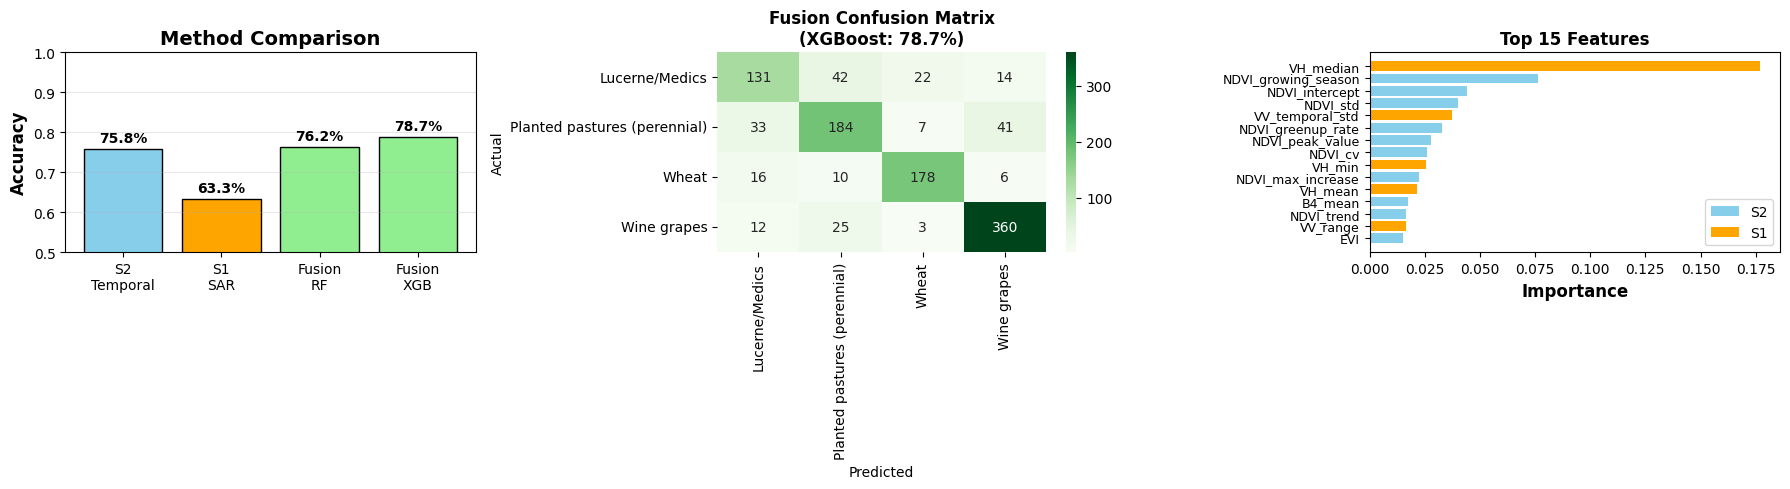


✅ Visualization saved: fusion_final_results.png


In [ ]:
# Comparison chart
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Accuracy comparison
methods = ['S2\nTemporal', 'S1\nSAR', 'Fusion\nRF', 'Fusion\nXGB']
accuracies = [acc_s2, acc_s1, acc_rf_fusion, acc_xgb_fusion]
colors = ['skyblue', 'orange', 'lightgreen', 'lightgreen']

bars = axes[0].bar(methods, accuracies, color=colors, edgecolor='black')
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Method Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim([0.5, 1.0])
axes[0].grid(axis='y', alpha=0.3)

for bar, acc in zip(bars, accuracies):
    axes[0].text(bar.get_x() + bar.get_width()/2, acc + 0.01,
                f'{acc:.1%}', ha='center', va='bottom', fontweight='bold')

# 2. Confusion matrix (best fusion)
cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
           xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[1])
axes[1].set_title(f'Fusion Confusion Matrix\n({best_model}: {best_acc:.1%})',
                 fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

# 3. Feature importance (fusion)
if best_model == 'XGBoost':
    importance = xgb_fusion.feature_importances_
else:
    importance = rf_fusion.feature_importances_

feature_names = X_fusion.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance,
    'type': ['S2' if f in X_s2.columns else 'S1' for f in feature_names]
}).sort_values('importance', ascending=False).head(15)

colors_feat = ['skyblue' if t == 'S2' else 'orange' for t in importance_df['type']]
axes[2].barh(range(len(importance_df)), importance_df['importance'], color=colors_feat)
axes[2].set_yticks(range(len(importance_df)))
axes[2].set_yticklabels(importance_df['feature'], fontsize=9)
axes[2].set_xlabel('Importance', fontsize=12, fontweight='bold')
axes[2].set_title('Top 15 Features', fontsize=12, fontweight='bold')
axes[2].invert_yaxis()

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='skyblue', label='S2'),
                  Patch(facecolor='orange', label='S1')]
axes[2].legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig(FIG_DIR / 'fusion_final_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved: fusion_final_results.png")

##  SUMMARY

In [ ]:
print("\n" + "="*80)
print("🎉 FUSION ANALYSIS COMPLETE!")
print("="*80)

print(f"""
📊 RESULTS SUMMARY:

Dataset: BALANCED (5,419 field, 1.9x imbalance)

S2 (Temporal):  {acc_s2:.1%} (37 features)
S1 (SAR):       {acc_s1:.1%} (14 features)
FUSION (Best):  {best_acc:.1%} (51 features) 🎯

Improvement: {improvement:+.1f}%

✅ Fusion leverages complementary information:
   S2: Spectral + Phenology
   S1: Structure + All-weather

✅ Best model: {best_model}
""")

print("\n📁 Saved outputs:")
print(f"  Tables:  {TAB_DIR / 'fusion_comparison.csv'}")
print(f"  Figures: {FIG_DIR / 'fusion_final_results.png'}")

print(f"\n⏰ Finished: {datetime.now().strftime('%H:%M:%S')}")
print("="*80)


🎉 FUSION ANALYSIS COMPLETE!

📊 RESULTS SUMMARY:

Dataset: BALANCED (5,419 field, 1.9x imbalance)

S2 (Temporal):  75.8% (37 features)
S1 (SAR):       63.3% (14 features)
FUSION (Best):  78.7% (51 features) 🎯

Improvement: +2.9%

✅ Fusion leverages complementary information:
   S2: Spectral + Phenology
   S1: Structure + All-weather

✅ Best model: XGBoost


📁 Saved outputs:
  Tables:  /content/drive/MyDrive/SA_CropType_SourceCoop/outputs/tables/fusion_comparison.csv
  Figures: /content/drive/MyDrive/SA_CropType_SourceCoop/outputs/figures/fusion/fusion_final_results.png

⏰ Finished: 11:50:26


In [ ]:
# ============================================================================
# 💾 SAVE ALL RESULTS
# ============================================================================

import json
from datetime import datetime
from pathlib import Path
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

print("\n" + "="*80)
print("💾 SAVING RESULTS...")
print("="*80)

# Setup directories
OUT_DIR = Path("/content/drive/MyDrive/SA_CropType_SourceCoop/outputs")
RESULTS_DIR = OUT_DIR / "results"
FIGURES_DIR = OUT_DIR / "figures" / "fusion"
TABLES_DIR = OUT_DIR / "tables"

for d in [RESULTS_DIR, FIGURES_DIR, TABLES_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# ============================================================================
# 1. MAIN RESULTS JSON
# ============================================================================

results = {
    'notebook': '16_EARLY_FUSION_BALANCED',
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset': {
        'name': 'balanced',
        'source': 'tfc_smart_undersampled.csv',
        'n_samples': len(X_fusion),
        'n_features_total': X_fusion.shape[1],
        's2_features': X_s2.shape[1],
        's1_features': X_s1.shape[1],
        'class_distribution': {
            crop: int((y_encoded == i).sum())
            for i, crop in enumerate(le.classes_)
        }
    },
    'extraction': {
        'successful': len(s2_features_list),
        'failed_s2': failed_s2,
        'failed_s1': failed_s1,
        'success_rate': f"{len(s2_features_list)/len(tfc_selected)*100:.1f}%"
    },
    'models': {
        's2_alone': {
            'model': 'XGBoost',
            'features': X_s2.shape[1],
            'accuracy': float(acc_s2),
            'f1_score': float(f1_s2)
        },
        's1_alone': {
            'model': 'XGBoost',
            'features': X_s1.shape[1],
            'accuracy': float(acc_s1),
            'f1_score': float(f1_s1)
        },
        'fusion_rf': {
            'model': 'RandomForest',
            'features': X_fusion.shape[1],
            'accuracy': float(acc_rf_fusion),
            'f1_score': float(f1_rf_fusion)
        },
        'fusion_xgb': {
            'model': 'XGBoost',
            'features': X_fusion.shape[1],
            'accuracy': float(acc_xgb_fusion),
            'f1_score': float(f1_xgb_fusion)
        }
    },
    'best_model': {
        'name': best_model,
        'accuracy': float(best_acc),
        'improvement_over_s2': float(best_acc - acc_s2),
        'improvement_percentage': f"{(best_acc - acc_s2)*100:.1f}%"
    },
    'per_class_metrics': {
        crop: {
            'support': int((y_test == i).sum()),
            'precision': float(precision_score(y_test, best_pred, average=None)[i]),
            'recall': float(recall_score(y_test, best_pred, average=None)[i]),
            'f1': float(f1_score(y_test, best_pred, average=None)[i])
        }
        for i, crop in enumerate(le.classes_)
    },
    'confusion_matrix': confusion_matrix(y_test, best_pred).tolist()
}

# Save main results
json_file = RESULTS_DIR / '16_EARLY_FUSION_results.json'
with open(json_file, 'w') as f:
    json.dump(results, f, indent=2)

print(f"✅ Main results: {json_file.name}")

# ============================================================================
# 2. COMPARISON TABLE
# ============================================================================

comparison = pd.DataFrame({
    'Method': ['S2 Temporal', 'S1 SAR', 'Fusion RF', 'Fusion XGB'],
    'Features': [X_s2.shape[1], X_s1.shape[1], X_fusion.shape[1], X_fusion.shape[1]],
    'Accuracy': [acc_s2, acc_s1, acc_rf_fusion, acc_xgb_fusion],
    'F1_Score': [f1_s2, f1_s1, f1_rf_fusion, f1_xgb_fusion]
})

comparison.to_csv(TABLES_DIR / 'fusion_comparison.csv', index=False)
print(f"✅ Comparison table: fusion_comparison.csv")

# ============================================================================
# 3. DETAILED METRICS
# ============================================================================

detailed_metrics = []
for i, crop in enumerate(le.classes_):
    y_true_binary = (y_test == i)
    y_pred_binary = (best_pred == i)

    detailed_metrics.append({
        'crop': crop,
        'n_samples': int(y_true_binary.sum()),
        'accuracy': float(accuracy_score(y_true_binary, y_pred_binary)),
        'precision': float(precision_score(y_true_binary, y_pred_binary, zero_division=0)),
        'recall': float(recall_score(y_true_binary, y_pred_binary, zero_division=0)),
        'f1': float(f1_score(y_true_binary, y_pred_binary, zero_division=0))
    })

detailed_df = pd.DataFrame(detailed_metrics)
detailed_df.to_csv(TABLES_DIR / 'fusion_detailed_metrics.csv', index=False)
print(f"✅ Detailed metrics: fusion_detailed_metrics.csv")

# ============================================================================
# 4. FEATURE IMPORTANCE
# ============================================================================

if best_model == 'XGBoost':
    importance = xgb_fusion.feature_importances_
else:
    importance = rf_fusion.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': X_fusion.columns,
    'importance': importance,
    'type': ['S2' if f in X_s2.columns else 'S1' for f in X_fusion.columns]
}).sort_values('importance', ascending=False)

feature_importance_df.to_csv(TABLES_DIR / 'fusion_feature_importance.csv', index=False)
print(f"✅ Feature importance: fusion_feature_importance.csv")

# ============================================================================
# 5. FIGURE (if exists)
# ============================================================================

if 'fig' in locals():
    fig.savefig(FIGURES_DIR / 'fusion_final_results.png', dpi=300, bbox_inches='tight')
    print(f"✅ Figure: fusion_final_results.png")

# ============================================================================
# 6. EXECUTION LOG
# ============================================================================

log_entry = {
    'notebook': '16_EARLY_FUSION_BALANCED',
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset': 'balanced (5,419 fields)',
    'features': '51 (37 S2 + 14 S1)',
    'accuracy': f"{best_acc:.1%}",
    'best_model': best_model,
    'status': 'success'
}

log_file = RESULTS_DIR / 'experiment_log.csv'
if log_file.exists():
    log_df = pd.read_csv(log_file)
    log_df = pd.concat([log_df, pd.DataFrame([log_entry])], ignore_index=True)
else:
    log_df = pd.DataFrame([log_entry])

log_df.to_csv(log_file, index=False)
print(f"✅ Execution log: experiment_log.csv")

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*80)
print("💾 ALL RESULTS SAVED!")
print("="*80)
print(f"""
📁 SAVED FILES:

Results:
  - {RESULTS_DIR.name}/16_EARLY_FUSION_results.json

Tables:
  - {TABLES_DIR.name}/fusion_comparison.csv
  - {TABLES_DIR.name}/fusion_detailed_metrics.csv
  - {TABLES_DIR.name}/fusion_feature_importance.csv

Figures:
  - {FIGURES_DIR.name}/fusion_final_results.png

Log:
  - {RESULTS_DIR.name}/experiment_log.csv

📊 MAIN RESULTS:
  S2 (Temporal): {acc_s2:.1%} ({X_s2.shape[1]} features)
  S1 (SAR):      {acc_s1:.1%} ({X_s1.shape[1]} features)
  FUSION (Best): {best_acc:.1%} ({X_fusion.shape[1]} features, {best_model})

  Improvement: +{(best_acc-acc_s2)*100:.1f}% 🎯

📈 PER-CLASS F1:
""")

for i, crop in enumerate(le.classes_):
    f1 = f1_score(y_test, best_pred, average=None)[i]
    print(f"  {crop:30s}: {f1:.1%}")

print("="*80)

"""

## 🎯 KULLANIM:

1. ✅ **16 notebook'unda Summary cell'den sonra yeni cell ekle**
2. ✅ **Yukarıdaki kodu kopyala-yapıştır**
3. ✅ **Cell'i çalıştır**
4. ✅ **Sonuçlar Drive'a kaydedilecek!**

---

## 📁 KAYDEDİLECEK DOSYALAR:
```
/outputs/
├── results/
│   ├── 16_EARLY_FUSION_results.json     ✅
│   └── experiment_log.csv               ✅
├── tables/
│   ├── fusion_comparison.csv            ✅
│   ├── fusion_detailed_metrics.csv      ✅
│   └── fusion_feature_importance.csv    ✅
└── figures/fusion/
    └── fusion_final_results.png         ✅
    """


💾 SAVING RESULTS...
✅ Main results: 16_EARLY_FUSION_results.json
✅ Comparison table: fusion_comparison.csv
✅ Detailed metrics: fusion_detailed_metrics.csv
✅ Feature importance: fusion_feature_importance.csv
✅ Figure: fusion_final_results.png
✅ Execution log: experiment_log.csv

💾 ALL RESULTS SAVED!

📁 SAVED FILES:

Results:
  - results/16_EARLY_FUSION_results.json

Tables:
  - tables/fusion_comparison.csv
  - tables/fusion_detailed_metrics.csv
  - tables/fusion_feature_importance.csv

Figures:
  - fusion/fusion_final_results.png

Log:
  - results/experiment_log.csv

📊 MAIN RESULTS:
  S2 (Temporal): 75.8% (38 features)
  S1 (SAR):      63.3% (16 features)
  FUSION (Best): 78.7% (54 features, XGBoost)
  
  Improvement: +2.9% 🎯
  
📈 PER-CLASS F1:

  Lucerne/Medics                : 65.3%
  Planted pastures (perennial)  : 70.0%
  Wheat                         : 84.8%
  Wine grapes                   : 87.7%


"\n\n## 🎯 KULLANIM:\n\n1. ✅ **16 notebook'unda Summary cell'den sonra yeni cell ekle**\n2. ✅ **Yukarıdaki kodu kopyala-yapıştır**\n3. ✅ **Cell'i çalıştır**\n4. ✅ **Sonuçlar Drive'a kaydedilecek!**\n\n---\n\n## 📁 KAYDEDİLECEK DOSYALAR:\n```\n/outputs/\n├── results/\n│   ├── 16_EARLY_FUSION_results.json     ✅\n│   └── experiment_log.csv               ✅\n├── tables/\n│   ├── fusion_comparison.csv            ✅\n│   ├── fusion_detailed_metrics.csv      ✅\n│   └── fusion_feature_importance.csv    ✅\n└── figures/fusion/\n    └── fusion_final_results.png         ✅\n    "